### Making the necessary imports

In [1]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.utils import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

/home/mwarren/Projects/CMPE452/Group Project/CMPE452/.venv/lib64/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-11 12:53:43.837716: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 12:53:44.160876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-11 12:53:44.160943: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU

In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data Preprocessing

In [14]:
df = pd.read_csv('/home/mwarren/Projects/CMPE452/Group Project/CMPE452/Datasets/Corona_NLP_train.csv', encoding='latin')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [15]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head(20)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
2534,6333,51285,"St.Louis, MO",17-03-2020,Next time an idiot says grocery store workers ...,Extremely Negative
22906,26705,71657,"St Louis, MO",25-03-2020,PLEASE SEE BELOW ??\r\r\n\r\r\nSoccer Master S...,Extremely Positive
26242,30041,74993,Spain-MÃ©xico-Colombia,02-04-2020,"With the world on lockdown, the physical aspec...",Positive
38942,42741,87693,New Delhi,12-04-2020,This piece was written in January 2008 by a fe...,Negative
26159,29958,74910,Mumbai,02-04-2020,Lesson Learned in past few days : Human beings...,Negative
27846,31645,76597,"Madison, WI, US, 53719",03-04-2020,Stickley furniture is built to withstand gener...,Extremely Positive
7740,11539,56491,"Lincoln, NE",19-03-2020,PSA: If youÂre not elderly or have an underly...,Negative
18262,22061,67013,?u?pd,23-03-2020,Shout-out to @Petco 375 E Altamonte Dr Suite 1...,Negative
5749,9548,54500,"Paris, France",19-03-2020,TTSA wishes everyone impacted by COVID 19 heal...,Extremely Positive
39488,43287,88239,United States,13-04-2020,Global oil prices have plummeted in the wake o...,Positive


In [ ]:
df = df[:24000]
len(df)

24000

In [ ]:
import re
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

In [ ]:
df['review'] = df['review'].apply(clean_text)

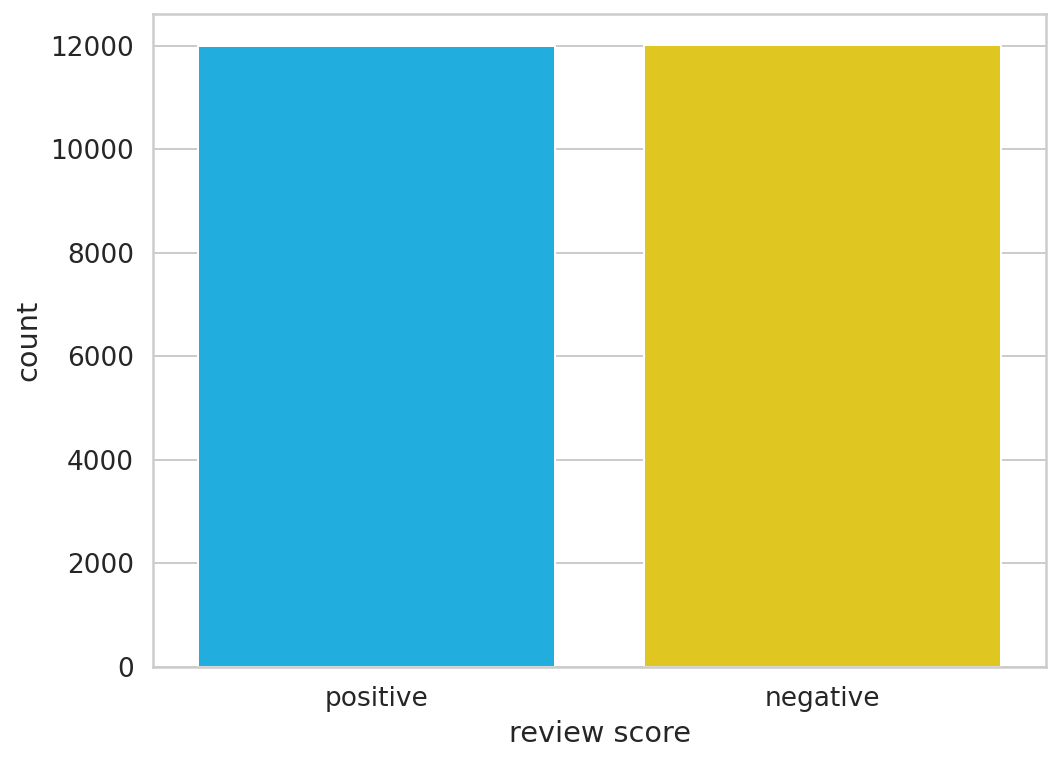

In [ ]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df.sentiment)
plt.xlabel('review score');

In [ ]:
def sentiment2label(sentiment):
    if sentiment == "positive":
        return 1
    else :
        return 0

df['sentiment'] = df['sentiment'].apply(sentiment2label)

In [ ]:
df['sentiment'].value_counts()

0    12006
1    11994
Name: sentiment, dtype: int64

In [ ]:
class_names = ['negative', 'positive']

### Playing with XLNetTokenizer

In [2]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading: 100%|██████████| 798k/798k [00:00<00:00, 3.67MB/s]
Downloading: 100%|██████████| 760/760 [00:00<00:00, 880kB/s]


In [3]:
input_txt = "India is my country. All Indians are my brothers and sisters"
encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=16, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=False)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [4]:
print('input_ids : ',encodings['input_ids'])

input_ids :  tensor([[ 837,   27,   94,  234,    9,  394, 7056,   41,   94, 4194,   21, 8301,
            4,    3]])


In [5]:
tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])

['▁India',
 '▁is',
 '▁my',
 '▁country',
 '.',
 '▁All',
 '▁Indians',
 '▁are',
 '▁my',
 '▁brothers',
 '▁and',
 '▁sisters',
 '<sep>',
 '<cls>']

In [6]:
type(encodings['attention_mask'])

torch.Tensor

In [7]:
attention_mask = pad_sequences(encodings['attention_mask'], maxlen=512, dtype=torch.Tensor ,truncating="post",padding="post")

In [8]:
attention_mask = attention_mask.astype(dtype = 'int64')
attention_mask = torch.tensor(attention_mask) 
attention_mask.flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [9]:
encodings['input_ids']

tensor([[ 837,   27,   94,  234,    9,  394, 7056,   41,   94, 4194,   21, 8301,
            4,    3]])

### Checking the distribution of token lengths

In [10]:
token_lens = []

for txt in df['review']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

NameError: name 'df' is not defined

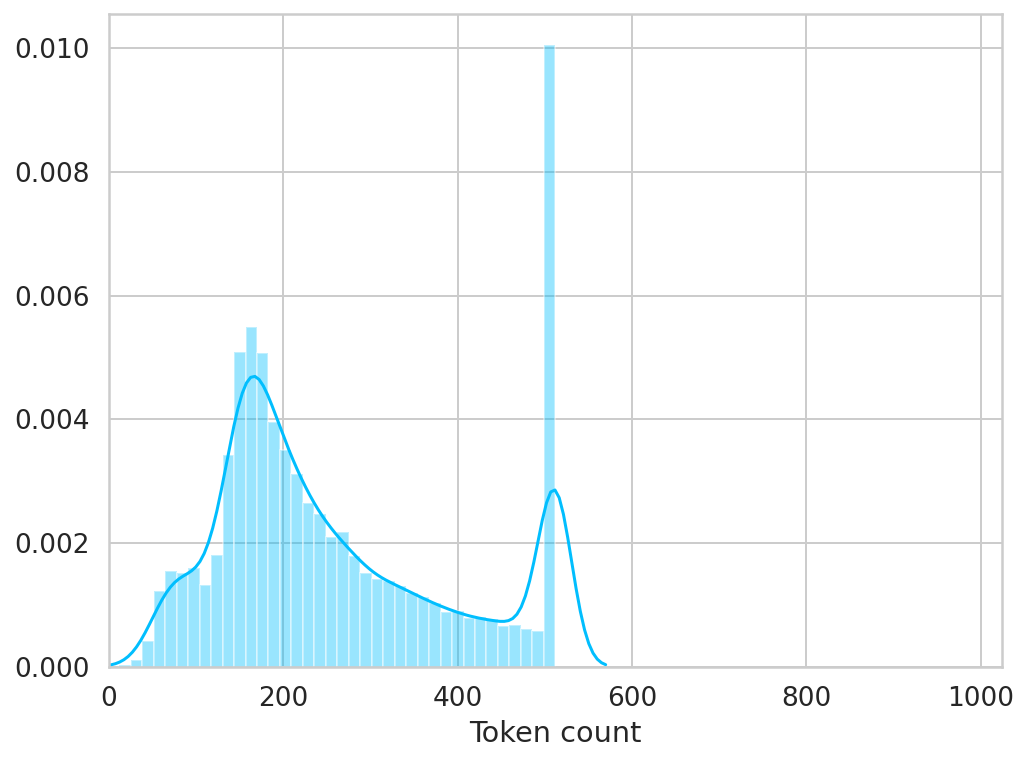

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 1024]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 512

### Custom Dataset class

In [ ]:
class ImdbDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'review_text': review,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.5, random_state=101)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=101)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((12000, 2), (6000, 2), (6000, 2))

### Custom Dataloader

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ImdbDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

### Loading the Pre-trained XLNet model for sequence classification from huggingface transformers

In [ ]:
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
model = model.to(device)

In [ ]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

### Setting Hyperparameters

In [ ]:
EPOCHS = 3

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

### Sanity check with one batch

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.reshape(4,512).shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 512])
torch.Size([4, 512])


In [ ]:
input_ids[0]

tensor([[   35,    26,   215,   435,    52,  1365,    21,  3353,     9,  4716,
          2537,    31,    58,   162,   192,    40,    24,  1288,   275,  2263,
            22,   182,    24,    17,    26, 16071,   778,    26,    29,  3469,
           107,   151,    24, 18041,  3401,    17, 16847,   939,     9,  1577,
           477,   805,    57,   195,   406,  1825,    22,   107,    21,    63,
          8008,  4623,    38,    58,  5754,     9,    17,  2369,    17,  2369,
            17, 29720,    63,   220,    26,    46,     9,  7174,    63,    26,
            88, 23064,   151,    37,    24,   321, 17785, 19167,    61,    51,
           106,  3404,  3728,   705,    21,   113, 30977,    23,    27,  2640,
           641,    20, 13943, 30436,     9,    17,  2369,    17,  2369,    35,
           937,    22,   287,   197,   124,    20,   166,  6454,    25,   124,
          1432,   545,   292,     9,  1988, 11247, 27288,    56,  9185,   675,
           110,    24, 16180,    21,    18,  4948,  

In [ ]:
outputs = model(input_ids.reshape(4,512), token_type_ids=None, attention_mask=attention_mask, labels=targets)
outputs

(tensor(0.7846, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor([[-0.8857, -0.5108],
         [-0.7872, -0.4824],
         [-0.7139, -0.5388],
         [-0.7889, -0.4051]], device='cuda:0', grad_fn=<AddmmBackward>))

In [ ]:
type(outputs[0])

torch.Tensor

### Defining the training step function

In [ ]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].reshape(4,512).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

### Defining the evaluation function

In [ ]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

### Fine-tuning the pre-trained model

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/drive/My Drive/NLP/Sentiment Analysis Series/models/xlnet_model.bin')
        best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.40229895541320243 Train accuracy 0.90525
Val loss 0.3111661048134168 Val accuracy 0.9308333333333333

Epoch 2/3
----------
Train loss 0.2054168249045809 Train accuracy 0.9594166666666667
Val loss 0.3556234954794248 Val accuracy 0.9366666666666666

Epoch 3/3
----------
Train loss 0.08638643393417199 Train accuracy 0.985
Val loss 0.3777355106075605 Val accuracy 0.9403333333333334

CPU times: user 2h 31min 50s, sys: 1h 36min 22s, total: 4h 8min 12s
Wall time: 4h 8min 44s


### Evaluation of the fine-tuned model

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/NLP/Sentiment Analysis Series/models/xlnet_model.bin'))

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df_test)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.956
Test Loss : 0.2740427735249201


In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.95      0.96      0.96      2976
    positive       0.96      0.96      0.96      3024

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



### Custom prediction function on raw text

In [ ]:
def predict_sentiment(text):
    review_text = text

    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids) 

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask) 

    input_ids = input_ids.reshape(1,512).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    outputs = outputs[0][0].cpu().detach()

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)

    print("Positive score:", probs[1])
    print("Negative score:", probs[0])
    print(f'Review text: {review_text}')
    print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
text = "Movie is the worst one I have ever seen!! The story has no meaning at all"
predict_sentiment(text)

Positive score: 0.00017438380746170878
Negative score: 0.999825656414032
Review text: Movie is the worst one I have ever seen!! The story has no meaning at all
Sentiment  : negative


In [ ]:
text = "This is the best movie I have ever seen!! The story is such a motivation"
predict_sentiment(text)

Positive score: 0.9998512268066406
Negative score: 0.00014876725617796183
Review text: This is the best movie I have ever seen!! The story is such a motivation
Sentiment  : positive
